In [12]:
import sys
import math
import numpy as np
import json
import Language_Data_Scraper as LD
sys.path.insert(0, '..')
from net_framework import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
node_num = range(1,25)
layer_num = range(1,4)


shape_collection = []
for node in node_num:
    if node < 3:
        shape_collection.append([node])

def trickle(arr, iteration_left, check):
    if iteration_left == 0:
        global shape_collection
        #running the int fxn to make sure we don't have floats
        mp = map(int, arr)
        x = list(mp)
        if check == sum(x):
            shape_collection.append(x)
    else:
        new_arr = [0]+ arr + [0]
        #recursively expanding the list symmetrically
        while new_arr[0] < new_arr[1]-2 and new_arr[-1] < new_arr[-2]-2:
            new_arr[0] += 1
            new_arr[1] -= 1
            new_arr[-1] += 1
            new_arr[-2] -= 1
        trickle(new_arr, iteration_left - 1, check)

for node in node_num:
    for layer in layer_num:
        if node//layer < 3:
            continue
        if layer%2 == 0:
            trickle([node/2, node/2], (layer-2)/2, node)
        else:
            trickle([node], (layer-1)/2, node)      

print(shape_collection)

[[1], [2], [3], [4], [5], [6], [3, 3], [7], [8], [4, 4], [9], [3, 3, 3], [10], [5, 5], [3, 4, 3], [11], [3, 5, 3], [12], [6, 6], [4, 4, 4], [13], [4, 5, 4], [14], [7, 7], [4, 6, 4], [15], [5, 5, 5], [16], [8, 8], [5, 6, 5], [17], [5, 7, 5], [18], [9, 9], [6, 6, 6], [19], [6, 7, 6], [20], [10, 10], [6, 8, 6], [21], [7, 7, 7], [22], [11, 11], [7, 8, 7], [23], [7, 9, 7], [24], [12, 12], [8, 8, 8]]


In [14]:
class TrainingHelper:

    def __init__(self, language_number, network_hidden_sizes, num_iters, test_train_split_percentage):
        self.num_iters = num_iters
        self.input_size = 3
        self.rate = 0.001
        self.language = LD.LanguageData(language_number)
        self.colors_num = self.language.colors_num()
        self.test_train_split_percentage = test_train_split_percentage
        self.network_shapes = [(self.input_size, s, self.colors_num) for s in network_hidden_sizes]

    def shuffle(self):
        lab_train, lab_test, chip_train, chip_test = train_test_split(self.language.lab_norm, self.language.chip_norm(), test_size = self.test_train_split_percentage,
        shuffle = True)
        input_train = torch.FloatTensor(lab_train)
        output_train = torch.FloatTensor(chip_train)
        input_test= torch.FloatTensor(lab_test)
        output_test = torch.FloatTensor(chip_test)
        return input_train, output_train, input_test, output_test

In [15]:
class Train:

    def __init__(self, num_average, network_hidden_sizes, num_iters, num_strikes, test_train_split_percentage, language_number):
        #Array of losses over training period for each network
        self.num_average = num_average
        self.num_strikes = num_strikes
        self.language_number = language_number
        self.output_file = {}
        for n in node_num:
            self.output_file[n] = {}
        self.th = TrainingHelper(language_number, network_hidden_sizes, num_iters, test_train_split_percentage)

    def run(self):
        for net_num, shape in enumerate(self.th.network_shapes):
            print("Training: ",shape)
            net_error_arr = []
            for j in range(self.num_average):
                print('Run ' + str(j+1))
                NN = Neural_Network(inputSize = shape[0], outputSize = shape[2],
                                    hiddenSize = shape[1] , learning_rate = self.th.rate)
                error_arr = []
                prev_error = 0
                strike = 0

                input_train, output_train, input_test, output_test = self.th.shuffle()

                for i in range(self.th.num_iters):  
                    NN.train(input_train, output_train)
                    validation_error = NN.l1error(output_test, NN(input_test))
                    #Printing error
                    if i == 0: 
                        dh = display("#" + str(i) + " Validation Error: " + str(validation_error), display_id=True)
                    else:
                        dh.update("#" + str(i) + " Validation Error: " + str(validation_error))
                    
                    #zero small error change
                    if i == 0:
                        strike = 0
                    #adding error to array
                    error_arr.append(validation_error)
                    #waiting for number 'too small' decreases or increases in validation error before ending training
                    if (prev_error < validation_error) and i > 100:
                        if strike > self.num_strikes:
                            print("Complete at iteration ", i, "\nFinal error: ", np.min(error_arr), "\n")
                            break
                        else:
                            strike += 1
                    prev_error = validation_error
                net_error_arr.append(np.min(error_arr))
            self.output_file[sum(shape[1])][len(shape[1])] = [np.mean(net_error_arr), np.std(net_error_arr)]

    def save_file(self):
        self.run()
        with open('validation_errors_{0}.json'.format(self.language_number), 'w') as f:
            json.dump(self.output_file, f)


In [ ]:
language_1 = Train(1, shape_collection, 100, 5, 0.2, 1)
language_1.save_file()

In [10]:
with open('validation_errors.json') as f:
    output_file=json.load(f)

(0.0, 0.2)

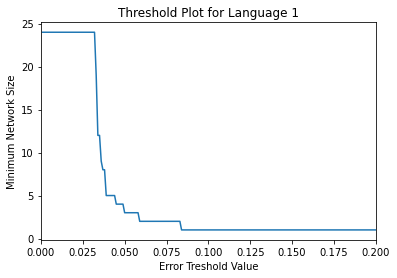

In [12]:
errors = []
for size in node_num:
    out_dict_for_size = output_file[str(size)]
    vals = list(out_dict_for_size.values())
    vals = np.array(vals)
    vals = vals[:,0]
    errors.append(np.min(vals))
errors = np.array(errors)

thresholds = np.arange(.001, 1, .001)

min_sizes = []
for threshold in thresholds:
    idx = 0
    for err in errors:
        if err <= threshold:
            break
        idx += 1
    if idx < len(node_num):
        min_sizes.append(node_num[idx])
    else:
        min_sizes.append(max(node_num))
        
plt.title('Threshold Plot for Language {0}'.format(1))
plt.plot(thresholds, min_sizes)
plt.xlabel('Error Treshold Value')
plt.ylabel('Minimum Network Size')
plt.xlim(0,0.2)